In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image

import os
import sys

In [2]:
from struct import unpack
from tqdm import tqdm
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []

In [3]:
def remove_bad_photos(folder):
    bad_data = []
    for dirs in os.listdir(folder):
        for file in os.listdir(os.path.join(folder,dirs)):
            try:
                im = JPEG(os.path.join(folder,dirs,file))
                im.decode()
            except Exception as e:
                print(e)
                print(f'Bad file: {os.path.join(folder,dirs,file)}')
                bad_data.append(os.path.join(folder,dirs,file))
    print(len(bad_data))
#     for img in bad_data:
#         os.remove(img)
remove_bad_photos('/kaggle/input/yoga-classification/dataset/yoga_set1/train')
remove_bad_photos('/kaggle/input/yoga-classification/dataset/yoga_set1/test')
remove_bad_photos('/kaggle/input/yoga-classification/dataset/yoga_set2/train')
remove_bad_photos('/kaggle/input/yoga-classification/dataset/yoga_set2/test')

0
0
0
0


In [4]:
train_ds_1 = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/yoga-classification/dataset/yoga_set1/train',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True   
)

test_ds_1 = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/yoga-classification/dataset/yoga_set1/test',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True   
)

# train_ds_2 = tf.keras.utils.image_dataset_from_directory(
#     '/kaggle/input/yoga-classification/dataset/yoga_set2/train',
#     labels='inferred',
#     label_mode='int',
#     color_mode='rgb',
#     batch_size=64,
#     image_size=(256,256),
#     shuffle=True   
# )

# test_ds_2 = tf.keras.utils.image_dataset_from_directory(
#     '/kaggle/input/yoga-classification/dataset/yoga_set2/test',
#     labels='inferred',
#     label_mode='int',
#     color_mode='rgb',
#     batch_size=64,
#     image_size=(256,256),
#     shuffle=True   
# )

Found 1156 files belonging to 3 classes.
Found 168 files belonging to 3 classes.


In [5]:
class_names = train_ds_1.class_names

In [6]:
class_names

['downdog', 'tree', 'warrior1']

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_1 = train_ds_1.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds_1 = test_ds_1.cache().prefetch(buffer_size=AUTOTUNE)

# train_ds_2 = train_ds_2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# test_ds_2 = test_ds_2.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
model = Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255),
    layers.Conv2D(128,3,padding='valid',activation='relu',input_shape=(256,256,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.6),
    layers.Conv2D(128,5,padding='valid',activation='leaky_relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dropout(0.4),
#     layers.Dense(256,activation='relu'),
    layers.Dense(3,activation='softmax')
])

In [77]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
            self.model.save("model.h5")
earlystopper = EarlyStopping(monitor='val_loss',patience=3)
saver=CustomSaver()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'],loss='sparse_categorical_crossentropy')
history = model.fit(train_ds_1,epochs=100,validation_data=test_ds_1,callbacks=[saver,earlystopper])

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 388ms/step - accuracy: 0.6664 - loss: 107.0416 - val_accuracy: 0.9107 - val_loss: 11.7888
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.7976 - loss: 27.2524 - val_accuracy: 0.8810 - val_loss: 11.2723
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.8928 - loss: 6.1693 - val_accuracy: 0.7857 - val_loss: 23.5324
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.9196 - loss: 3.2973 - val_accuracy: 0.8988 - val_loss: 6.6185
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.9547 - loss: 1.7661 - val_accuracy: 0.8988 - val_loss: 12.6128
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.9525 - loss: 1.6309 - val_accuracy: 0.8512 - val_loss: 13.3871
Epoch 7/100
14/37 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.9688 - loss: 1.1528

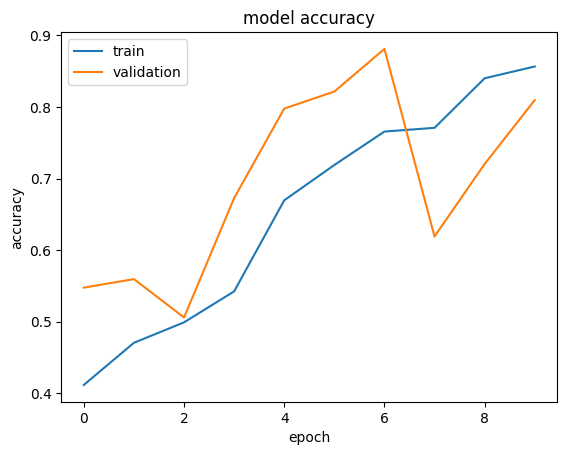

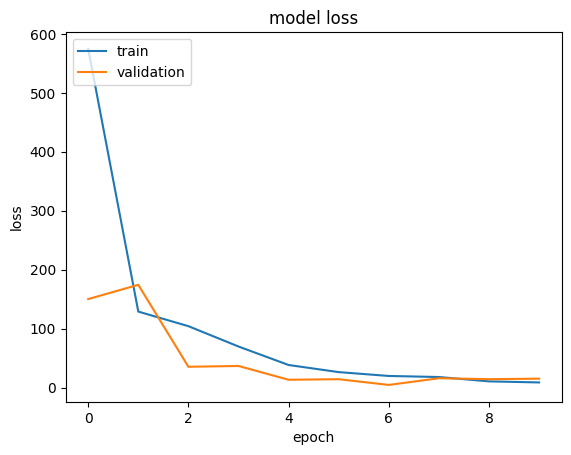

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [59]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 254, 254, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 123, 123, 128)  │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 476288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 476288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │     1,428,867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,527,563 (21.09 MB)

 Trainable params: 1,842,435 (7.03 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 3,684,872 (14.06 MB)

In [68]:
model.save('yoga_v3.h5')

In [69]:
img = keras.preprocessing.image.load_img('/kaggle/input/yoga-classification/dataset/final_test/yoga_set1/3.jpg', target_size=(256, 256))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
prediction_class = class_names[np.argmax(predictions)]
print(predictions, prediction_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
[[0. 1. 0.]] tree


In [17]:
tf.__version__

'2.15.0'

In [62]:
model_loaded= tf.keras.models.load_model('yoga_v3.h5')
model_loaded.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 254, 254, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 123, 123, 128)  │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 476288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 476288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │     1,428,867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,842,693 (7.03 MB)

 Trainable params: 1,842,435 (7.03 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2 (12.00 B)